## 动量法
目标函数有关自变量的梯度代表了目标函数在自变量当前位置下降最快的方向。因此，梯度下降也叫作最陡下降（steepest descent）。在每次迭代中，梯度下降根据自变量当前位置，沿着当前位置的梯度更新自变量。然而，如果自变量的迭代方向仅仅取决于自变量当前位置，这可能会带来一些问题。

构造一个二维空间中的例子来说明：

epoch 20, x1 -0.943467, x2 -0.000073


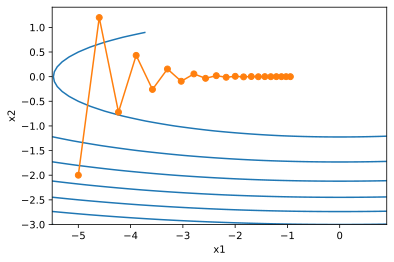

In [36]:
%matplotlib inline
import torch
import my_utils
import matplotlib.pyplot as plt
import numpy as np

eta = 0.4

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

def gd_2d(x1, x2, s1, s2):
    return (x1 - eta * 0.2 * x1, x2 - eta * 4 * x2, 0, 0)

my_utils.show_trace_2d(f_2d, my_utils.train_2d(gd_2d))
# my_utils.use_svg_display()
# plt.plot(*zip(*my_utils.train_2d(gd_2d)), '-o', color='#ff7f0e')
# x1, x2 = np.meshgrid(np.arange(-5.5, 1.0, 0.1), np.arange(-3.0, 1.0, 0.1))
# plt.contour(x1, x2, f_2d(x1, x2), colors='#1f77b4')
# plt.xlabel('x1')
# plt.ylabel('x2')
# plt.savefig('momentum1.svg')

该例子中，自变量在竖直方向比在水平方向移动幅度更大。因此，需要一个较小的学习率从而避免自变量在竖直方向上越过目标函数最优解。然而，这会造成自变量在水平方向上朝最优解移动变慢。

将学习率调得稍大一点，此时自变量在竖直方向不断越过最优解甚至逐渐发散。

epoch 20, x1 -0.387814, x2 -1673.365109


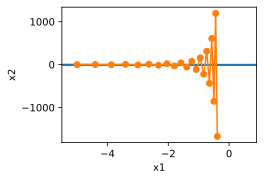

In [12]:
eta = 0.6
my_utils.show_trace_2d(f_2d, my_utils.train_2d(gd_2d))

引入动量法解决这一问题。设$\vec{g}_t$表示时间步$t$的小批量随机梯度，引入速度$\vec{v}_t$，将模型参数$\vec{x}_t$按照如下方式更新：

$$
\vec{v}_t \leftarrow \gamma \vec{v}_{t-1} + \eta_t \vec{g}_t \\
\vec{x}_t \leftarrow \vec{x}_{t-1} - \vec{v}_t,
$$

其中$\gamma \in [0, 1)$，$\vec{v}_0$初始化为$\vec{0}$。

先观察引入动量之后的效果：

epoch 20, x1 -0.062843, x2 0.001202


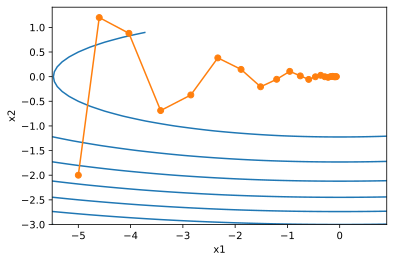

In [37]:
def momentum_2d(x1, x2, v1, v2):
    v1 = gamma * v1 + eta * 0.2 * x1
    v2 = gamma * v2 + eta * 4 * x2
    return x1 - v1, x2 - v2, v1, v2

eta, gamma = 0.4, 0.5
my_utils.show_trace_2d(f_2d, my_utils.train_2d(momentum_2d))
# my_utils.use_svg_display()
# plt.plot(*zip(*my_utils.train_2d(momentum_2d)), '-o', color='#ff7f0e')
# x1, x2 = np.meshgrid(np.arange(-5.5, 1.0, 0.1), np.arange(-3.0, 1.0, 0.1))
# plt.contour(x1, x2, f_2d(x1, x2), colors='#1f77b4')
# plt.xlabel('x1')
# plt.ylabel('x2')
# plt.savefig('momentum2.svg')

显然，动量法在竖直方向上的移动更加平滑，且在水平方向上更快逼近最优解。

将学习率调的大一些，观察动量法效果：

epoch 20, x1 0.007188, x2 0.002553


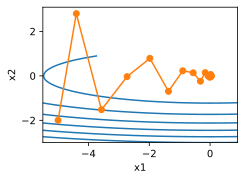

In [15]:
eta, gamma = 0.6, 0.5
my_utils.show_trace_2d(f_2d, my_utils.train_2d(momentum_2d))

没有越过最优解，也没有逐渐发散。

### 1 理论分析

#### 1.1 指数加权移动平均

给定超参数$\gamma \in [0, 1)$，当前时间步$t$的变量$y_t$是上一时间步$t-1$的变量$y_{t-1}$和当前时间步的另一变量$x_t$的线性组合：

$$
y_t = \gamma y_{t-1} + (1 - \gamma) x_t,
$$

对$y_t$按时间步展开：

\begin{eqnarray*}
y_t &=& (1 - \gamma) x_t + \gamma y_{t-1} \\
&=& (1-\gamma) \Big( x_t + \gamma x_{t-1} + \gamma^2 x_{t-2} \Big) + \gamma^3 y_{t-3} \\
&=& ...
\end{eqnarray*}

我们想忽略更高阶的项，因此需要分析$\gamma$的指数$n$。为了和$e$建立关联，令$n = \frac{1}{1 - \gamma}$。则$\gamma = 1 - \frac{1}{n}$，且

$$
\lim_{\gamma \to 1} \gamma^n = \lim_{\gamma \to 1} \gamma^{1/(1-\gamma)} =
\lim_{n \to \infty} \Big( 1 - \frac{1}{n} \Big)^n = \exp(-1) \approx 0.3679.
$$

我们将$\exp(-1)$（即$\lim_{\gamma \to 1} \gamma^{1/(1-\gamma)}$的近似）视为一个比较小的数，并忽略包含$\lim_{\gamma \to 1} \gamma^{1/(1-\gamma)}$在内的高阶小量，那么，以$\gamma = 0.95$为例，$y_t$近似为

$$
y_t \approx 0.05 \sum_{i=0}^{19} 0.95^i x_{t-i} = \frac{\sum_{i=0}^{19} 0.95^i x_{t-i}}{20}.
$$

因此，我们常常将$y_t$看作是对最近$\frac{1}{1 - \gamma}$个时间步的$x_t$值的加权平均，距离当前时间步越近权重越大。

#### 1.2 理解动量法

在动量法中，速度$\vec{v}_t$的更新可改写为：

$$
\vec{v}_t \leftarrow \gamma \vec{v}_{t-1} (1 - \gamma) \Big( \frac{\eta_t}{1-\gamma} \Big).
$$

这实际上是对序列$\{\frac{\eta_{t-i}}{(1-\gamma)} \vec{g}_{t-i}: i=0, ..., \frac{1}{1-\gamma} -1 \}$做了指数加权移动平均。动量法在每个时间步的自变量更新量近似于将最近$\frac{1}{1-\gamma}$个时间步的普通更新量（即学习率乘以梯度）做了指数加权移动平均后再除以$1-\gamma$（因为又除以了$1-\gamma$，所以其实是加权和）。这意味着自变量在各个方向上的移动幅度不仅取决当前梯度，还取决于过去的各个梯度在各个方向上是否一致。在上文的例子中，数值方向的更新量在两个方向上相互抵消，从而减缓了在竖直方向上的移动幅度。相比之下，所有梯度在水平方向上为正。因此，我们可以采用稍大的学习率，可以在解决上述问题的同时更快收敛。

### 2 从零开始实现

In [19]:
features, labels = my_utils.get_NASA_data()

def init_momentum_states():
    # w和b分别有对应的速度变量
    v_w = torch.zeros((features.shape[-1], 1), dtype=torch.float32)
    v_b = torch.zeros(1, dtype=torch.float32)
    return (v_w, v_b)

def sgd_momentum(params, states, hyperparams):
    for p, v in zip(params, states):
        v.data = hyperparams['momentum'] * v.data + hyperparams['lr'] * p.grad.data
        p.data -= v.data

loss: 0.244423, 0.058914 sec per epoch


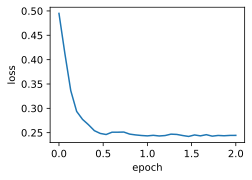

In [22]:
my_utils.opt_train(sgd_momentum, init_momentum_states(), {'lr': 0.02, 'momentum': 0.5}, features, labels)

保持学习率不变，增大momentum：这会导致被加权平均的梯度减少，从而让容易震荡的方向比之前更震荡。

loss: 0.245240, 0.061407 sec per epoch


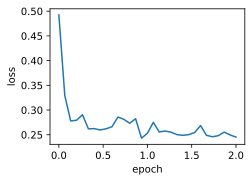

In [23]:
my_utils.opt_train(sgd_momentum, init_momentum_states(),
              {'lr': 0.02, 'momentum': 0.9}, features, labels)

再减小学习率：loss曲线就平缓了很多。

loss: 0.244658, 0.058518 sec per epoch


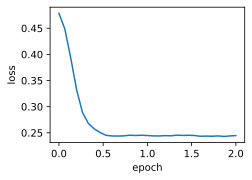

In [25]:
my_utils.opt_train(sgd_momentum, init_momentum_states(),
              {'lr': 0.004, 'momentum': 0.9}, features, labels)

### 3 简洁实现

loss: 0.246848, 0.050820 sec per epoch


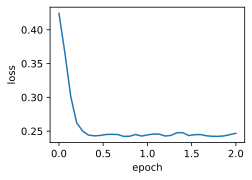

In [27]:
my_utils.opt_train_torch(torch.optim.SGD,
                         {'lr': 0.004, 'momentum': 0.9}, features, labels)